In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import math
import time
import re
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

In [18]:
BASE_DIR = '../'

train_path = os.path.join(BASE_DIR, 'data', 'bank_dataset', 'bank_train.csv')
test_path  = os.path.join(BASE_DIR, 'data', 'bank_dataset', 'bank_test.csv')
val_path   = os.path.join(BASE_DIR, 'data', 'bank_dataset', 'bank_val.csv')

In [19]:
def load_data(one_hot_encoding, numeric_cols, filename, values_dict = {}):
    df = pd.read_csv(filename, delimiter = ';')
    Y = df['y'].copy()
    Y  = Y.to_numpy()
    for i in range(Y.shape[0]):
        if Y[i] == 'yes':
            Y[i] = 1
        else:
            Y[i] = 0 #Assigning 0 to nan values
    
    Y = Y.astype('int64')
    df = df.drop(['y'],axis=1)
    
    if one_hot_encoding == False:
        return df, Y
    
    if one_hot_encoding == True and values_dict == {}:
        for col in df.columns:
            if col not in numeric_cols:
                values = list(set(list(df[col])))
                values_dict[col] = values
                
                for i in range(df.shape[0]):
                    df[col][i] = values_dict[col].index(df[col][i])
        return df, Y, values_dict
    
    elif one_hot_encoding == True:
        for col in df.columns:
            if col not in numeric_cols:
                for i in range(df.shape[0]):
                    if df[col][i] in values_dict[col]:
                        df[col][i] = values_dict[col].index(df[col][i])
                    else:
                        df[col][i] = -1
        return df, Y

In [4]:
def entropy_num(X,Y):
    median = np.median(X)
    boolean_flag = X > median
    # X_left  = X[boolean_flag == False]
    # X_right = X[boolean_flag == True]
    Y_left  = Y[boolean_flag == False]
    Y_right = Y[boolean_flag == True]
    
    p1,p2 = 0,0
    
    if Y_left.shape[0] > 0:
        s1 = np.sum(Y_left)
        s1 = max(s1, Y_left.shape[0] - s1)
        p1 = float(s1)/float(Y_left.shape[0])
        p1 = - p1 * np.log(p1)
        
        if Y_left.shape[0] > s1:
            p_t = float(Y_left.shape[0]-s1)/float(Y_left.shape[0])
            p_t = -p_t * np.log(p_t)        
            p1 += p_t
        
        p1 = p1*(float(Y_left.shape[0]))/float(Y.shape[0])
    
    if Y_right.shape[0] > 0:
        s2 = np.sum(Y_right)
        s2 = max(s2, Y_right.shape[0] - s2)
        p2 = float(s2)/float(Y_right.shape[0])
        p2 = - p2 * np.log(p2)
        
        if Y_right.shape[0] > s2:
            p_t = float(Y_right.shape[0]-s2)/float(Y_right.shape[0])
            p_t = -p_t * np.log(p_t)
            p2 += p_t
        
        p2 = p2*(float(Y_right.shape[0]))/float(Y_right.shape[0])
    
    # print(p1,p2,X,Y)
    
    return p1+p2

def entropy_categorical(X,Y):
    val = list(set(list(X)))
    val_count = dict.fromkeys(val,[0,0])
    
    for i in range(X.shape[0]):
        val_count[X[i]][1] += 1
        if Y[i] == 1:
            val_count[X[i]][0] += 1
    entr = 0

    for category,count in val_count.items():
        p = 0
        val_count[category][0] = max(count[0], count[1] - count[0])
        if count[1] > 0:
            p = float(val_count[category][0])/float(count[1])
            p = -p * np.log(p)

            p_t = float(count[1]-val_count[category][0])/float(count[1])
            p_t = -p_t * np.log(p_t)

            p += p_t
            
            p = p * (float(count[1]))/float(Y.shape[0])        
        entr += p
    
    return entr
    

In [5]:
def information_gain(attribute, one_hot_encoding, numeric_cols, parent_entr, indices, X, Y):
    X_new = np.array((X.iloc[indices])[attribute])
    Y_new = Y[indices]
    entr  = 0
    info_parent = parent_entr
    
    if attribute in numeric_cols:
        entr = entropy_num(X_new, Y_new)
        # print("Info Gain:",attribute,entr)
    else:
        if one_hot_encoding == False: # Multi split
            entr = entropy_categorical(X_new, Y_new)
        else:
            entr = entropy_num(X_new, Y_new)
    
    
    
    return info_parent - entr

In [6]:
def best_attribute(one_hot_encoding, rem_attr, numeric_cols, parent, indices, X, Y):
    best_attr = ''
    info_gain = -float('inf')
    
    parent_entr = 0
    # if parent == None:
    #     parent_entr = 0
    # elif parent.attr in numeric_cols:
    #     parent_entr = entropy_num
    
    for attr in X.columns:
        if attr in numeric_cols or attr in rem_attr:            
            temp = information_gain(attr, one_hot_encoding, numeric_cols, parent_entr, indices, X, Y)
            # print("Best_Attr Selection:",attr,temp)
            if temp > info_gain:
                info_gain = temp
                best_attr = attr
    
    return best_attr, info_gain

In [7]:
class dc_node:

    # indices coming at this node
    def __init__(self,parent,indices,depth,decision,median=0,value=None,attribute=None):
        self.parent = parent
        self.indices = indices

        self.child = []
        self.depth = depth
        self.attr  = attribute

        self.decision = decision
        self.median   = median
        self.value    = value

In [27]:
def construct_decision_tree(one_hot_encoding, rem_attr, numeric_cols, parent, indices, X, Y, MAX_DEPTH):
    Y_new = np.array(Y[indices])
    if np.sum(Y_new) > (Y_new.shape[0] - np.sum(Y_new)):
        decision = 1
    else:
        decision = 0
    
    if indices.shape[0] == 1 or (parent != None and parent.depth >= MAX_DEPTH):
        if parent == None:
            return dc_node(parent, indices, 1, decision)
        else:
            return dc_node(parent, indices, parent.depth+1, decision)
    else:
        attr,gain = best_attribute(one_hot_encoding, rem_attr, numeric_cols, parent, indices, X, Y)
        
        depth = 0
        if parent == None:
            depth = 0
        else:
            depth = parent.depth + 1
        node = dc_node(parent,indices,depth,decision,attribute=attr)
        
        # print("Attr:",attr,",  Gain: ",gain,",  Depth:",depth)
        # print("Rem:",rem_attr)
        # print("Numeric:",numeric_cols)
        # print("Indices:",indices)
        
        # if gain > 0:
        X_new = np.array((X.iloc[indices])[attr])
        
        if attr in numeric_cols or (one_hot_encoding == True):
            median = np.median(X_new)
            node.median = median
            
            boolean_flag = X_new > median
            ind_left  = indices[boolean_flag == False]
            ind_right = indices[boolean_flag == True]
            
            if one_hot_encoding == True and attr not in numeric_cols:
                boolean_flag = (X_new % 2 == 0)
                ind_left  = indices[boolean_flag == False]
                ind_right = indices[boolean_flag == True]
                rem_attr.remove(attr)
                
            
            # print("Left: ",ind_left,ind_left.shape[0])
            # print("Right: ",ind_right,ind_right.shape[0])
            # print("Indices: ", indices, indices.shape[0])

            if ind_left.shape[0] > 0:
                left  = construct_decision_tree(one_hot_encoding, rem_attr.copy(), numeric_cols, node, ind_left, X, Y, MAX_DEPTH)
                left.value = 'left'
                node.child.append(left)
            
            if ind_right.shape[0] > 0:
                right = construct_decision_tree(one_hot_encoding, rem_attr.copy(), numeric_cols, node, ind_right, X, Y, MAX_DEPTH)
                right.value = 'right'
                node.child.append(right)
                                    
        elif one_hot_encoding == False and attr in rem_attr:
            rem_attr.remove(attr)
            val = list(set(list(X_new)))
            for i in val:
                ind = indices[X_new == i]
                if ind.shape[0] > 0:
                    child = construct_decision_tree(one_hot_encoding, rem_attr.copy(), numeric_cols, node, ind, X, Y, MAX_DEPTH)
                    child.value = i
                    node.child.append(child)
        return node

In [9]:
def decision_tree(one_hot_encoding, categorical_cols, numeric_cols, X, Y, MAX_DEPTH = 20):
    indices = np.arange(0,X.shape[0])
    dc_tree = construct_decision_tree(one_hot_encoding, categorical_cols.copy(), numeric_cols, None, indices, X, Y, MAX_DEPTH)
    return dc_tree

In [10]:
def predict_recursive(one_hot_encoding, x, root, numeric_cols):
    if len(root.child) == 0:
        return root.decision
    else:
        val = ''
        if root.attr in numeric_cols:
            if x[root.attr] > root.median:
                val = 'right'
            else:
                val = 'left'
        elif one_hot_encoding == True:
            index = x[root.attr]
            if index % 2 == 0:
                val = 'right'
            else:
                val = 'left'
        else:            
            val = x[root.attr]
        
        for i in range(len(root.child)):
            if root.child[i].value == val:
                return predict_recursive(one_hot_encoding, x, root.child[i], numeric_cols)
        return root.decision
    
def predict(one_hot_encoding, X, root, numeric_cols):
    Y_pred = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
    # for i in range(1):
        z = predict_recursive(one_hot_encoding, X.iloc[i], root, numeric_cols)
        Y_pred[i] = int(z)
    Y_pred = Y_pred.astype('int64')
    return Y_pred

In [11]:
def print_tree(root):
    if root.parent==None:
        print("Root Node. Feature Used to Split-> " + str(root.attr))
        print("Decision: " + str(root.decision))
        child_list = []
        for i in range(len(root.child)):
            child_list.append(root.child[i].value)
            
        print("Child Values -> " + str(child_list))

        for c in root.child:
            print_tree(c)
    else:
        print("Child splitted on feature -> " + str(root.parent.attr))
        print("Decision: " + str(root.decision))
        print("Value of child is -> " + str(root.value))
        # print("Feature to be used -> " + str(root.attr))
        child_list = []
        for i in range(len(root.child)):
            child_list.append(root.child[i].value)
            
        print("Child Values -> " + str(child_list))

        for c in root.child:
            print_tree(c)        

In [23]:
def accuracy(y1,y2):
    count = 0.0
    for i in range(y1.shape[0]):
        if y1[i] == y2[i]:
            count+=1.0
    return (count)/(y1.shape[0])

In [29]:
def bfs(root):
    i = 0
    node_list = [root]
    while i < len(node_list):
        top_node = node_list[i]
        if len(top_node.child) > 0:
            for c in top_node.child:
                node_list.append(c)
        i+=1
    return node_list        

In [20]:
PART = 'a'
one_hot_encoding = False
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

print("Loading data...")
Xtrain, Ytrain = load_data(one_hot_encoding, numeric_cols, train_path)

print("Loading test data...")
Xtest, Ytest = load_data(one_hot_encoding, numeric_cols, test_path)

print("Loading val data...")
Xval, Yval = load_data(one_hot_encoding, numeric_cols, val_path)

Loading data...
Loading test data...
Loading val data...


In [70]:
PART = 'a'
one_hot_encoding = True
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

print("Loading data...")
Xtrain, Ytrain, values_dict = load_data(one_hot_encoding, numeric_cols, train_path, {})

print("Loading test data...")
Xtest, Ytest = load_data(one_hot_encoding, numeric_cols, test_path, values_dict)

print("Loading val data...")
Xval, Yval = load_data(one_hot_encoding, numeric_cols, val_path, values_dict)

Loading data...
Loading test data...
Loading val data...


In [71]:
# if PART == 'a':
prediction = {}

MAX_DEPTH = 20

for depth in range(MAX_DEPTH+1):
    
    print("Current Depth:",depth)
    
    temp = []
    
    print("Training ...")
    start = time.time()    
    dc_tree = decision_tree(one_hot_encoding, categorical_cols, numeric_cols, Xtrain, Ytrain, depth)    
    end = time.time()
    
    temp.append(round(end-start,5))
    start = time.time()

    print("Prediction ...")
    y_pred = predict(one_hot_encoding, Xtrain, dc_tree, numeric_cols)
    acc1 = round(accuracy(y_pred,Ytrain),3)
    print("Train Accuracy: {}%".format(100.0*acc1))

    y_pred2 = predict(one_hot_encoding, Xtest, dc_tree, numeric_cols)
    acc2 = round(accuracy(y_pred2,Ytest),3)
    print("Test Accuracy: {}%".format(100.0*acc2))

    y_pred3 = predict(one_hot_encoding, Xval, dc_tree, numeric_cols)
    acc3 = round(accuracy(y_pred3,Yval),3)
    print("Val Accuracy: {}%\n\n".format(100.0*acc3))
    
    end = time.time()
    temp.append(round(end-start,5))
            
    temp.extend([acc1, acc2, acc3])
    
    node_list = bfs(dc_tree)
    temp.insert(0,len(node_list))
    
    prediction[str(depth)] = temp

Current Depth: 0
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 1
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 2
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 3
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 4
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 5
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 6
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.5%
Val Accuracy: 88.6%


Current Depth: 7
Training ...
Prediction ...
Train Accuracy: 88.4%
Test Accuracy: 87.4%
Val Accuracy: 88.7%


Current Depth: 8
Training ...
Prediction ...
Train Accuracy: 88.6%
Test Accuracy: 87.6%
Val Accuracy: 88.5%


Current De

In [72]:
print(prediction)

train_acc = []
test_acc = []
val_acc = []
total_nodes = []
time_train = []
time_pred = []

for i in prediction:
    total_nodes.append(prediction[i][0])
    time_train.append(prediction[i][1])
    time_pred.append(prediction[i][2])
    train_acc.append(prediction[i][3])
    test_acc.append(prediction[i][4])
    val_acc.append(prediction[i][5])

# {'0': [3, 0.25335, 5.79341, 0.884, 0.875, 0.886], '1': [7, 0.51829, 6.48452, 0.884, 0.875, 0.886], '2': [15, 0.80137, 7.35196, 0.884, 0.875, 0.886], '3': [29, 1.36934, 7.37438, 0.884, 0.875, 0.886], '4': [53, 1.32061, 6.9076, 0.884, 0.875, 0.886], '5': [91, 1.85822, 7.40847, 0.884, 0.875, 0.886], '6': [151, 3.37831, 9.56334, 0.884, 0.875, 0.886], '7': [251, 3.40111, 10.80501, 0.884, 0.875, 0.886], '8': [404, 3.66044, 11.47056, 0.884, 0.875, 0.886], '9': [646, 5.30307, 9.7246, 0.884, 0.874, 0.887], '10': [996, 6.57841, 9.7283, 0.884, 0.874, 0.887], '11': [1475, 9.1379, 10.54124, 0.885, 0.874, 0.886], '12': [2112, 9.83179, 9.59183, 0.886, 0.874, 0.885], '13': [2898, 12.83813, 9.31074, 0.887, 0.874, 0.886], '14': [3797, 19.55251, 11.98687, 0.888, 0.872, 0.885], '15': [4755, 22.48475, 12.16239, 0.89, 0.871, 0.884], '16': [5664, 28.47441, 12.01079, 0.891, 0.872, 0.884], '17': [6477, 30.86752, 10.35908, 0.891, 0.871, 0.884], '18': [7247, 35.12374, 13.57276, 0.891, 0.871, 0.884], '19': [8017, 53.39867, 17.70567, 0.891, 0.871, 0.884], '20': [8787, 52.41782, 17.06274, 0.891, 0.871, 0.884]}


{'0': [3, 0.31705, 5.33835, 0.884, 0.875, 0.886], '1': [7, 0.43253, 5.2421, 0.884, 0.875, 0.886], '2': [15, 0.66857, 5.47073, 0.884, 0.875, 0.886], '3': [31, 0.87907, 5.73833, 0.884, 0.875, 0.886], '4': [62, 1.05706, 6.15257, 0.884, 0.875, 0.886], '5': [121, 1.42302, 6.93454, 0.884, 0.875, 0.886], '6': [219, 1.65839, 6.87896, 0.884, 0.875, 0.886], '7': [388, 2.06141, 7.22146, 0.884, 0.874, 0.887], '8': [670, 2.76444, 7.63186, 0.886, 0.876, 0.885], '9': [1159, 3.91822, 7.76115, 0.887, 0.877, 0.887], '10': [1905, 5.47081, 8.21427, 0.889, 0.877, 0.885], '11': [3032, 7.96787, 8.42848, 0.891, 0.875, 0.885], '12': [4614, 11.19088, 8.61657, 0.895, 0.876, 0.885], '13': [6660, 15.3253, 12.16928, 0.901, 0.875, 0.881], '14': [9259, 25.74125, 10.94353, 0.905, 0.876, 0.882], '15': [12303, 28.3695, 11.45831, 0.909, 0.876, 0.881], '16': [15379, 44.36459, 11.388, 0.914, 0.873, 0.877], '17': [18313, 49.33252, 12.57808, 0.915, 0.873, 0.876], '18': [21097, 64.35721, 12.74111, 0.916, 0.872, 0.875], '19': 

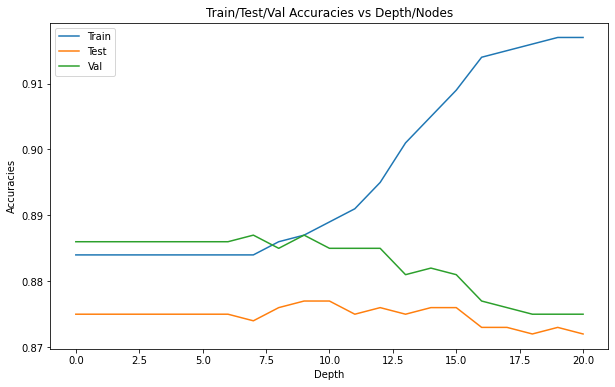

In [74]:
def graph_plot(train, test, val, total_nodes, filename):
    
    # plt.figure()
    # plt.figure.set_figwidth(4)
    # plt.figure.set_figheight(1)    
    plt.figure(figsize=(10, 6))
    
    x = [int(i) for i in range(len(train))]
    # x = total_nodes
    
    plt.title("Train/Test/Val Accuracies vs Depth/Nodes")
    plt.xlabel("Depth")
    plt.ylabel("Accuracies")
    plt.plot(x, train,label="Train")
    plt.plot(x, test,label="Test")
    plt.plot(x, val, label="Val")
    # for i in range(len(train)):
    #     plt.annotate("Nodes: " + str(total_nodes[i]), xy=(x[i], train[i]+1))
    plt.legend()
    plt.savefig(filename)
    
    plt.show()

# graph_plot(train_acc, test_acc, val_acc, total_nodes, "../output/decision_trees_accuracy_vs_nodes.jpg")
graph_plot(train_acc, test_acc, val_acc, total_nodes, "../output/decision_trees_accuracy_vs_depth_ohe.jpg")
    

In [104]:
# PART B (POST PRUNING)

PART = 'b'
one_hot_encoding = True
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

print("Loading data...")
Xtrain, Ytrain, values_dict = load_data(one_hot_encoding, numeric_cols, train_path, {})
# Xtrain, Ytrain = load_data(one_hot_encoding, numeric_cols, train_path, {})
# values_dict = {}

print("Loading test data...")
Xtest, Ytest = load_data(one_hot_encoding, numeric_cols, test_path, values_dict)

print("Loading val data...")
Xval, Yval = load_data(one_hot_encoding, numeric_cols, val_path, values_dict)

Loading data...
Loading test data...
Loading val data...


In [91]:
dc_tree = decision_tree(one_hot_encoding, categorical_cols, numeric_cols, Xtrain, Ytrain, 9)

In [92]:
node_list = bfs(dc_tree)
train_accuracy = []
test_accuracy = []
val_accuracy = []
node_count = [len(node_list)]

train_accuracy.append(accuracy_score(predict(one_hot_encoding, Xtrain, dc_tree, numeric_cols), Ytrain))
test_accuracy.append(accuracy_score(predict(one_hot_encoding, Xtest, dc_tree, numeric_cols), Ytest))
val_accuracy.append(accuracy_score(predict(one_hot_encoding, Xval, dc_tree, numeric_cols), Yval))


In [93]:
print(train_accuracy, test_accuracy, val_accuracy)
print(len(node_list))
# [0.8930269851802699] [0.8896261888962619] [0.8920831490490934]

[0.8869166113691661] [0.8767971687679716] [0.8865546218487395]
1159


In [94]:
iteration = 0
val_best_accuracy = val_accuracy[-1]

while True:
    iteration += 1
    previous_accuracy = val_accuracy[-1]
    after_accuracy    = None
    tree_best_node    = tree
    
    count = 0
    # node_list = node_list[::-1]
    for node in node_list:
        count = count + 1
        if len(node.child) > 0:
            child_temp = node.child
            node.child = []
            after_accuracy = accuracy_score(predict(one_hot_encoding, Xval, dc_tree, numeric_cols), Yval)
            
            if count%10 == 0:
                print("After: ",after_accuracy,"Val Best: ",val_best_accuracy,"Node number:",count)
                
            if after_accuracy > val_best_accuracy:
                val_best_accuracy = after_accuracy
                tree_best_node = node
                # break
            node.child = child_temp
    
    print("Best Accuracy: ",val_best_accuracy,"  Previous: ",previous_accuracy)
    if val_best_accuracy > previous_accuracy:
        tree_best_node.child = [] # PRUNING
    
        node_list = bfs(dc_tree)
        train_accuracy.append(accuracy_score(predict(one_hot_encoding, Xtrain, dc_tree, numeric_cols), Ytrain))
        test_accuracy.append(accuracy_score(predict(one_hot_encoding, Xtest, dc_tree, numeric_cols), Ytest))
        val_accuracy.append(accuracy_score(predict(one_hot_encoding, Xval, dc_tree, numeric_cols), Yval))
        node_count.append(len(node_list))

        print("Iteration: {}, Val_accuracy: {}, Node_count: {}".format(iteration, val_accuracy[-1], node_count[-1]))        
    else:
        break

After:  0.885891198584697 Val Best:  0.8869969040247678 Node number: 10
After:  0.8863334807607254 Val Best:  0.8869969040247678 Node number: 20
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 30
After:  0.8863334807607254 Val Best:  0.8869969040247678 Node number: 40
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 50
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 60
After:  0.8869969040247678 Val Best:  0.8869969040247678 Node number: 70
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 80
After:  0.8867757629367536 Val Best:  0.8869969040247678 Node number: 90
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 100
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 110
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 120
After:  0.8865546218487395 Val Best:  0.8869969040247678 Node number: 130
After:  0.8865546218487395 Val Best:  0.88699690

In [124]:
print(node_count)
print("Train: ", train_accuracy)
print("Test: ", test_accuracy)
print("Val: ", val_accuracy)

[1704, 1595, 1294, 1288]
Train:  [0.8954877239548772, 0.8947135589471356, 0.8945753151957532, 0.8944370714443707]
Test:  [0.8854235788542358, 0.8885202388852024, 0.8885202388852024, 0.8891838088918381]
Val:  [0.8911985846970367, 0.8931888544891641, 0.8934099955771783, 0.8936311366651923]


In [126]:
# Part C Random Forest
def load_data_rf(numeric_cols, filename, values_dict = {}):
    df = pd.read_csv(filename, delimiter = ';')
    Y = df['y'].copy()
    Y  = Y.to_numpy()
    for i in range(Y.shape[0]):
        if Y[i] == 'yes':
            Y[i] = 1
        else:
            Y[i] = 0 #Assigning 0 to nan values
    
    Y = Y.astype('int64')
    df = df.drop(['y'],axis=1)
                
    if values_dict == {}:
        for col in df.columns:
            if col not in numeric_cols:
                values = list(set(list(df[col])))
                values_dict[col] = values                
                for i in range(df.shape[0]):
                    temp = df[col][i]
                    df[col][i] = np.zeros(len(values))
                    df[col][i][values_dict[col].index(temp)] = 1
        return df, Y, values_dict
    
    else:
        for col in df.columns:
            if col not in numeric_cols:
                for i in range(df.shape[0]):
                    temp = df[col][i]
                    df[col][i] = np.zeros(len(values_dict[col]))
                    if temp in values_dict[col]:
                        df[col][i][values_dict[col].index(temp)] = 1                        
        return df, Y    

In [127]:
PART = 'c'
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

print("Loading train data...")
Xtrain_rf, Ytrain_rf, values_dict_rf = load_data_rf(numeric_cols, train_path, {})

print("Loading test data...")
Xtest_rf, Ytest_rf = load_data_rf(numeric_cols, test_path, values_dict_rf)

print("Loading val data...")
Xval_rf, Yval_rf = load_data_rf(numeric_cols, val_path, values_dict_rf)

Loading train data...
Loading test data...


TypeError: load_data_rf() takes from 2 to 3 positional arguments but 4 were given

In [129]:
best_params = {
    "num_estimators": 14,
    "bootstrap": True,
    "num_features": 52,
    "accuracy": -1
}

n_estimators = [50, 150, 250, 350, 450]
max_features = [0.1, 0.3, 0.5, 0.7, 0.9]
min_samples_split = [2, 4, 6, 8, 10]

bootstrap_list = [True, False]
max_features_list = np.arange(1,Xtrain_rf.shape[1])

In [ ]:
for n in n_estimators:
    for bs in bootstrap_list:
        for m in max_features_list:
            rf = RandomForestClassifier(n_estimators=n, criterion="entropy", bootstrap=bs, max_features=m, min_samples_split=10)
            # rf.fit(Xtrain_rf, Ytrain_rf.reshape(-1))
            rf.fit(Xtrain, Ytrain.reshape(-1))
            # acc = accuracy_score(Yval_rf, np.array(rf.predict(Xval_rf), dtype=int))
            acc = accuracy_score(Yval, np.array(rf.predict(Xval), dtype=int))
            if acc > best_params['accuracy']:
                print("Accuracy: ", acc)                
                best_params['num_estimators'] = n
                best_params['bootstrap'] = bs
                best_params['num_features'] = m
                best_params['accuracy'] = acc
                break

print(best_params)

In [ ]:
def load_data(filename, values_dict={}):
    df = np.asarray(pd.read_csv(filename, header=None, dtype=int))
    if values_dict == {}:
        for i in range(df.shape[1]):
            length = list(set(list(df[:,i])))
            values_dict[i] = length
            for j in range(df.shape[0]):
                temp = df[j][i]
                df[j][i] = np.zeros(len(length))
                df[j][i][temp-1] = 1
    else:
        for i in range(df.shape[1]):
            length = values_dict[i]
            for j in range(df.shape[0]):
                temp = df[j][i]
                df[j][i] = np.zeros(len(length))
                df[j][i][temp-1] = 1
            # df[j] = df[j].ravel()
        
    return df[:,0:df.shape[1]-1], df[:,df.shape[1]-1]